In [1]:
import os
import numpy as np

# 일관된 출력을 위해 유사난수 초기화
# np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

# 핸즈온 머신러닝 2판 - Chapter 8 차원 축소

## 8.3 PCA

## 8.3.2 주성분

﻿파이썬 코드 넘파이로 주성분을 구한 후 처음 두 개의 PC를 정의하는 두 개의 단위 벡터 추출하기

In [ ]:
# numpy의 svd()함수를 사용

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centeered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

### 8.3.3 d차원으로 투영하기

첫 두 개의 주성분으로 정의된 평면에 훈련 세트를 투영

In [ ]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

### 8.3.4 사이킷런 사용하기

PCA 모델을 사용해 데이터셋의 차원을 2로 줄이는 코드

In [3]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

print('X.shape:', X.shape)

X.shape: (60, 3)


In [4]:
# 사이킷런의 PCA 모델
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

print('singular value :', pca.singular_values_)
print('singular vector :\n', pca.components_.T)

singular value : [6.77645005 2.82403671]
singular vector :
 [[-0.93636116  0.34027485]
 [-0.29854881 -0.90119108]
 [-0.18465208 -0.2684542 ]]


### 8.3.5 설명된 분산의 비율

explained_variance_ratio_ 변수에 저장된 주성분의 설명된 분산의 비율(explained variance ratio)도 유용한 정보 중 하나이다.

In [6]:
#3D 데이터셋의 처음 두 주성분에 대한 설명된 분산의 비율
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

### 8.3.6 적절한 차원 수 선택하기

In [7]:
#훈련 세트의 분산을 95%로 유지하는 데 필요한 최소한의 차원 수 계산

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >=0.95) + 1
print('선택할 차원 수 : ', d)

선택할 차원 수 :  2


In [8]:
# n_components=d로 설정(0~1 사이의 값) 하여 PCA를 계산할 수 도 있다.

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

print('principal component vec :\n', pca.components_.T)

principal component vec :
 [[-0.93636116  0.34027485]
 [-0.29854881 -0.90119108]
 [-0.18465208 -0.2684542 ]]


### 8.3.7 압축을 위한 PCA

In [9]:
from tensorflow.keras.datasets import mnist

# MNIST load
(train_x, train_y), (test_x, test_y) = mnist.load_data()

# reshape
train_x = train_x.reshape(-1, 28*28) 

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(train_x)

print('선택한 차원(픽셀) 수 :', pca.n_components_)

선택한 차원(픽셀) 수 : 154


In [10]:
# 위에서 압축한 X_reduced에다가 PCA의 inverse_transform() 메소드를 이용햐 784 차원으로 복원
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(train_x)
X_recovered = pca.inverse_transform(X_reduced)

In [11]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

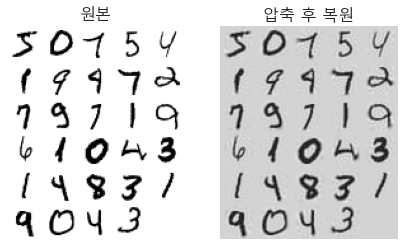

In [12]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(train_x[::2100])
plt.title("원본", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("압축 후 복원", fontsize=16)
plot_digits(X_recovered[::2100])

### 8.3.8 랜덤 PCA

In [13]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(train_x)
X_reduced.shape

(60000, 154)

### 8.3.9 점진적 PCA

In [14]:
#Scikit-Learn에서는 IncrementalPCA를 통해 Incremental PCA를 사용할 수 있다. 
#MNIST 데이터를 100개의 미니배치로 나눠 PCA를 수행

from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)
for X_batch in np.array_split(train_x, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(train_x)

In [15]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

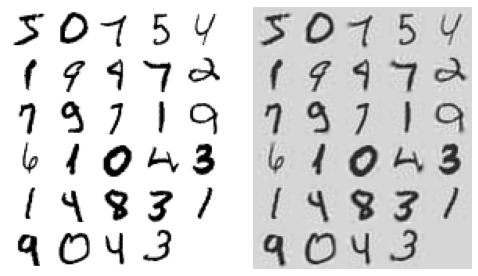

In [16]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(train_x[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [19]:
# numpy의 memmap 파이썬 클래스를 사용하는 방법

X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components = 154, batch_size = batch_size)
inc_pca.fit(X_mm)

NameError: name 'filename' is not defined

## 8.4 커널 PCA

In [20]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [21]:
#사이킷런의 KernelPCA를 사용해 RBF커널로 kPCA를 적용
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma = 0.04)
X_reduced = rbf_pca.fit_transform(X)

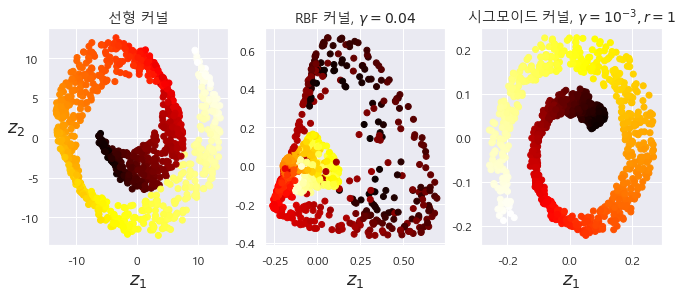

In [22]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "선형 커널"), (132, rbf_pca, "RBF 커널, $\gamma=0.04$"), (133, sig_pca, "시그모이드 커널, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

### 8.4.1 커널 선택과 하이퍼 파라미터 튜닝

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [24]:
#가장 좋은 커널과 하이퍼파라미터
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


﻿투영된 샘플을 훈련 세트로, 원본 샘플의 타깃으로 하는 지도 학습 회귀 모델을 학습

In [25]:
#투영된 샘플을 훈련 세트로, 원본 샘플을 타킷으로 하는 지도 학습 회귀모델을 훈련
# 사이킷런의 fit_inverse_transform = True를 지정하면 이를 자동으로 수행

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [26]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

7.563721361984842e-27

## 8.5 LLE

In [27]:
#사이킷런의 LocallyLinearEmbedding을 사용해 스위스 롤 펼치기
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 10)
X_reduced = lle.fit_transform(X)

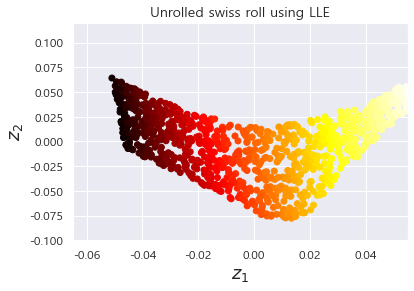

In [28]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()